# Stock Market Prediction using CNN-LSTM model
This project is about analysis of Stock Market and providing predictions to the stockholders. For this, we used CNN-LSTM approach to create a blank model, then use it to train on stock market data. Further implementation is discussed below...

In [4]:
import os
import math
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
#plt.style.use('dark_background')
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
import yfinance as yf
from datetime import datetime

yf.pdr_override()

data = pdr.get_data_yahoo('AAPL', start='2005-02-25', end=datetime.now())
# Show the data
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-02-25,1.600357,1.605536,1.574821,1.589107,1.352518,915510400
2005-02-28,1.595714,1.612143,1.570000,1.602143,1.363613,651610400
2005-03-01,1.606786,1.611071,1.577143,1.589286,1.352670,468188000
2005-03-02,1.580357,1.603214,1.574286,1.575714,1.341119,458161200
2005-03-03,1.584643,1.586071,1.472143,1.492500,1.270294,1411653600


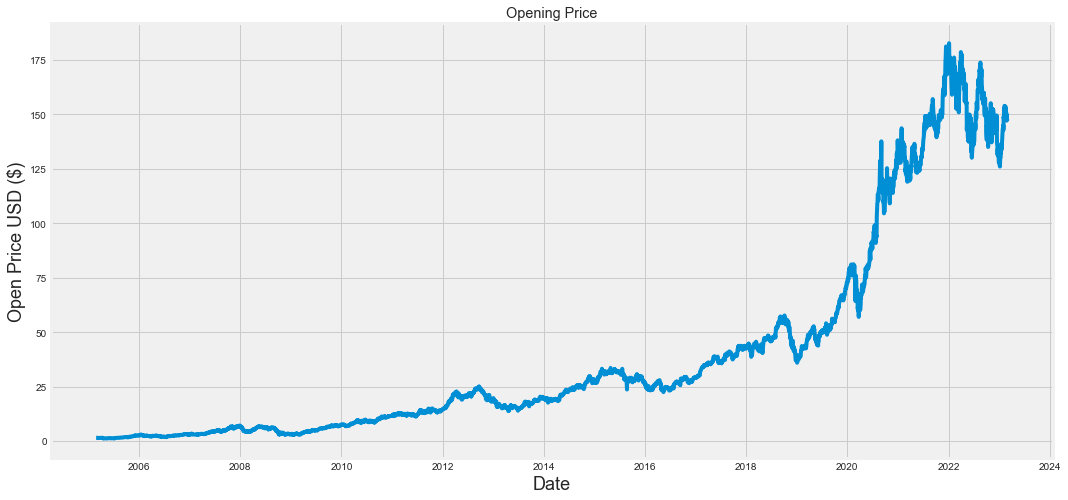

In [5]:
plt.figure(figsize=(16,8))
plt.title('Opening Price')
plt.plot(data['Open'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.show()

# Data Preprocessing and Analysis

In [6]:
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

Before preprocessing data, a function to fetch real-time stock data (using Alpha Vantage API) is made

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4533 entries, 2005-02-25 to 2023-02-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4533 non-null   float64
 1   High       4533 non-null   float64
 2   Low        4533 non-null   float64
 3   Close      4533 non-null   float64
 4   Adj Close  4533 non-null   float64
 5   Volume     4533 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 247.9 KB


In [8]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4533.000000,4533.000000,4533.000000,4533.000000,4533.000000,4.533000e+03
mean,39.304124,39.750811,38.866530,39.326252,37.777820,4.125323e+08
std,46.386584,46.971592,45.830853,46.426451,46.476401,3.916300e+08
min,1.221429,1.258214,1.182500,1.218929,1.037453,3.519590e+07
25%,6.694643,6.769286,6.597500,6.678571,5.684255,1.176844e+08
50%,22.121071,22.316786,21.846430,22.137857,19.002150,2.762564e+08
75%,45.080002,45.667500,44.654999,45.227501,43.593166,5.934600e+08
max,182.630005,182.940002,179.119995,182.009995,180.683868,3.372970e+09


In [9]:
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Filling null columns with mean values....

In [10]:
data.reset_index(drop=True, inplace=True)
data.fillna(data.mean(), inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
0,1.600357,1.605536,1.574821,1.589107,1.352518,915510400
1,1.595714,1.612143,1.570000,1.602143,1.363613,651610400
2,1.606786,1.611071,1.577143,1.589286,1.352670,468188000
3,1.580357,1.603214,1.574286,1.575714,1.341119,458161200
4,1.584643,1.586071,1.472143,1.492500,1.270294,1411653600


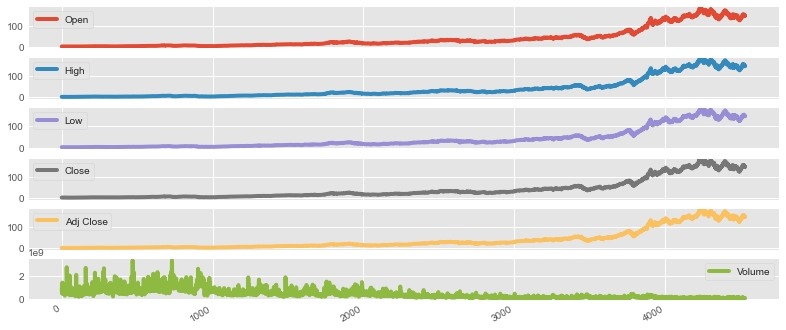

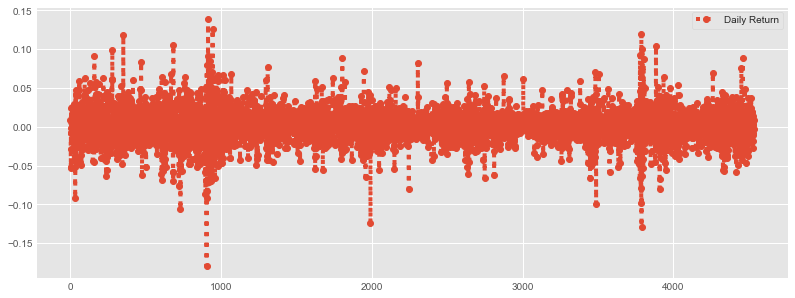

            Open        High         Low       Close   Adj Close      Volume  \
0       1.600357    1.605536    1.574821    1.589107    1.352518   915510400   
1       1.595714    1.612143    1.570000    1.602143    1.363613   651610400   
2       1.606786    1.611071    1.577143    1.589286    1.352670   468188000   
3       1.580357    1.603214    1.574286    1.575714    1.341119   458161200   
4       1.584643    1.586071    1.472143    1.492500    1.270294  1411653600   
...          ...         ...         ...         ...         ...         ...   
4528  148.869995  149.949997  147.160004  148.910004  148.910004    51011300   
4529  150.089996  150.339996  147.240005  149.399994  149.399994    48394200   
4530  147.110001  147.190002  145.720001  146.710007  146.710007    55418200   
4531  147.710007  149.169998  147.449997  147.919998  147.919998    44998500   
4532  147.050003  149.080002  146.830002  147.410004  147.410004    50455400   

      MA for 10 days  MA for 50 days  M

Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
MA for 10 days     0
MA for 50 days     0
MA for 100 days    0
Daily Return       0
dtype: int64

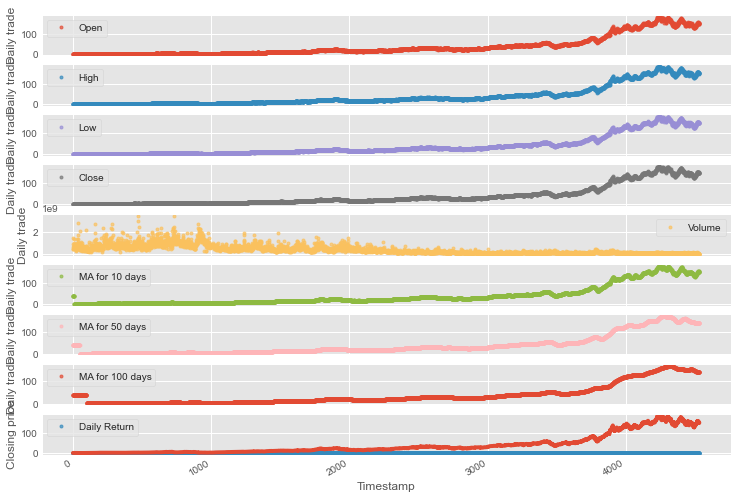

In [11]:
data.plot(legend=True,subplots=True, figsize = (12, 6))
plt.show()


data.shape
data.size
data.describe(include='all').T
data.dtypes
data.nunique()
ma_day = [10,50,100]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    data[column_name]=pd.DataFrame.rolling(data['Close'],ma).mean()

data['Daily Return'] = data['Close'].pct_change()
# plot the daily return percentage
data['Daily Return'].plot(figsize=(12,5),legend=True,linestyle=':',marker='o')
plt.show()


data.reset_index(drop=True, inplace=True)
data.fillna(data.mean(), inplace=True)
data.head()

data.nunique()

data.sort_index(axis=1,ascending=True)

cols_plot = ['Open', 'High', 'Low','Close','Volume','MA for 10 days','MA for 50 days','MA for 100 days','Daily Return']
axes = data[cols_plot].plot(marker='.', alpha=0.7, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = data
print(df)

data.isnull().sum()

After that, we'll visualize the data for understanding, this is shown below...

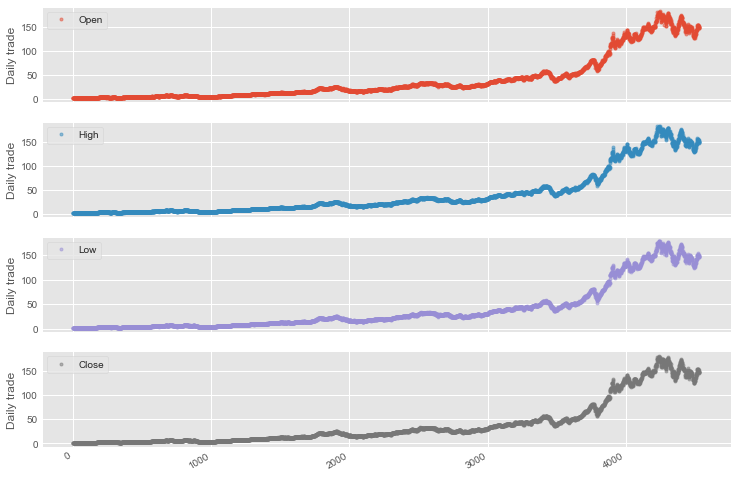

In [12]:
cols_plot = ['Open', 'High', 'Low','Close']
axes = data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

Then we'd print the data after making changes and dropping null data

            Open        High         Low       Close   Adj Close      Volume  \
0       1.600357    1.605536    1.574821    1.589107    1.352518   915510400   
1       1.595714    1.612143    1.570000    1.602143    1.363613   651610400   
2       1.606786    1.611071    1.577143    1.589286    1.352670   468188000   
3       1.580357    1.603214    1.574286    1.575714    1.341119   458161200   
4       1.584643    1.586071    1.472143    1.492500    1.270294  1411653600   
...          ...         ...         ...         ...         ...         ...   
4528  148.869995  149.949997  147.160004  148.910004  148.910004    51011300   
4529  150.089996  150.339996  147.240005  149.399994  149.399994    48394200   
4530  147.110001  147.190002  145.720001  146.710007  146.710007    55418200   
4531  147.710007  149.169998  147.449997  147.919998  147.919998    44998500   
4532  147.050003  149.080002  146.830002  147.410004  147.410004    50455400   

      MA for 10 days  MA for 50 days  M

,count,mean,std,min,25%,50%,75%,max
Open,4533.0,3.930412e+01,4.638658e+01,1.221429e+00,6.694643e+00,2.212107e+01,4.508000e+01,1.826300e+02
High,4533.0,3.975081e+01,4.697159e+01,1.258214e+00,6.769286e+00,2.231679e+01,4.566750e+01,1.829400e+02
Low,4533.0,3.886653e+01,4.583085e+01,1.182500e+00,6.597500e+00,2.184643e+01,4.465500e+01,1.791200e+02
Close,4533.0,3.932625e+01,4.642645e+01,1.218929e+00,6.678571e+00,2.213786e+01,4.522750e+01,1.820100e+02
Adj Close,4533.0,3.777782e+01,4.647640e+01,1.037453e+00,5.684255e+00,1.900215e+01,4.359317e+01,1.806839e+02
Volume,4533.0,4.125323e+08,3.916300e+08,3.519590e+07,1.176844e+08,2.762564e+08,5.934600e+08,3.372970e+09
MA for 10 days,4533.0,3.925501e+01,4.625937e+01,1.280607e+00,6.673357e+00,2.217843e+01,4.483450e+01,1.783320e+02
MA for 50 days,4533.0,3.895304e+01,4.555834e+01,1.328314e+00,6.585571e+00,2.254567e+01,4.435355e+01,1.726638e+02
MA for 100 days,4533.0,3.859068e+01,4.473840e+01,1.394139e+00,6.912546e+00,2.235808e+01,4.435180e+01,1.694848e+02
Daily Return,4533.0,1.215991e-03,2.077112e-02,-1.791952e-01,-8.678301e-03,9.506655e-04,1.196188e-02,1.390495e-01


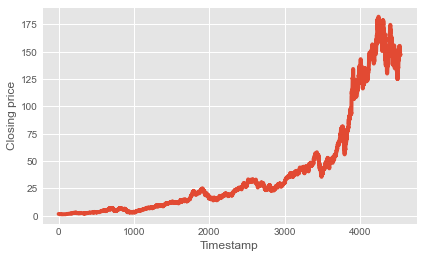

In [13]:
plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = data
print(df)

df.describe().transpose()

The data has been analysed but it must be converted into data of shape [100,1] to make it easier for CNN to train on... Else it won't select necessary features and the model will fail

In [14]:
from sklearn.model_selection import train_test_split

X = []
Y = []
window_size=100
for i in range(1 , len(df) - window_size -1 , 1):
    first = df.iloc[i,2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 2] - first) / first)
    temp2.append((df.iloc[i + window_size, 2] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

3544
887


# Training part

This part has 2 subparts: CNN and LSTM

For CNN, the layers are created with sizes 64,128,64 with kernel size = 3. In every layer, TimeDistributed function is added to track the features for every temporal slice of data with respect to time. In between, MaxPooling layers are added.

After that, it's passed to Bi-LSTM layers

In [15]:
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

model = tf.keras.Sequential()

# Creating the Neural Network model here...
# CNN layers
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
# model.add(Dense(5, kernel_regularizer=L2(0.01)))

# LSTM layers
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

#Final layers
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

history = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=40,batch_size=40, verbose=1, shuffle =True)

Epoch 1/40
89/89 [==============================] - 9s 32ms/step - loss: 0.0182 - mse: 0.0182 - mae: 0.0980 - val_loss: 0.0087 - val_mse: 0.0087 - val_mae: 0.0697
Epoch 2/40
89/89 [==============================] - 2s 18ms/step - loss: 0.0087 - mse: 0.0087 - mae: 0.0696 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0592
Epoch 3/40
89/89 [==============================] - 2s 19ms/step - loss: 0.0068 - mse: 0.0068 - mae: 0.0616 - val_loss: 0.0057 - val_mse: 0.0057 - val_mae: 0.0573
Epoch 4/40
89/89 [==============================] - 2s 19ms/step - loss: 0.0058 - mse: 0.0058 - mae: 0.0580 - val_loss: 0.0061 - val_mse: 0.0061 - val_mae: 0.0577
Epoch 5/40
89/89 [==============================] - 2s 18ms/step - loss: 0.0060 - mse: 0.0060 - mae: 0.0583 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0524
Epoch 6/40
89/89 [==============================] - 2s 17ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0562 - val_loss: 0.0046 - val_mse: 0.0046 - val_mae: 0.0513
Epoch 7/40
89/89 [====

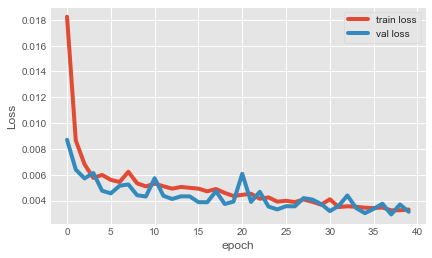

In [16]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

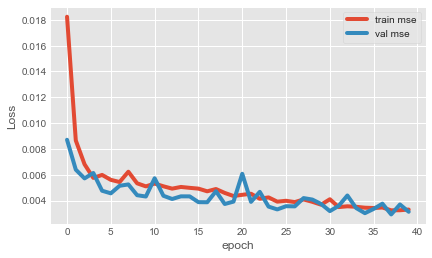

In [17]:
plt.plot(history.history['mse'], label='train mse')
plt.plot(history.history['val_mse'], label='val mse')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

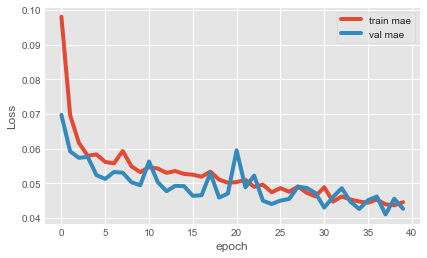

In [18]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [19]:
# After the model has been constructed, we'll summarise it
from tensorflow.keras.utils import plot_model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 1, 98, 64)        256       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 49, 64)        0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 47, 128)       24704     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 1, 23, 128)       0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 1, 21, 64)        2

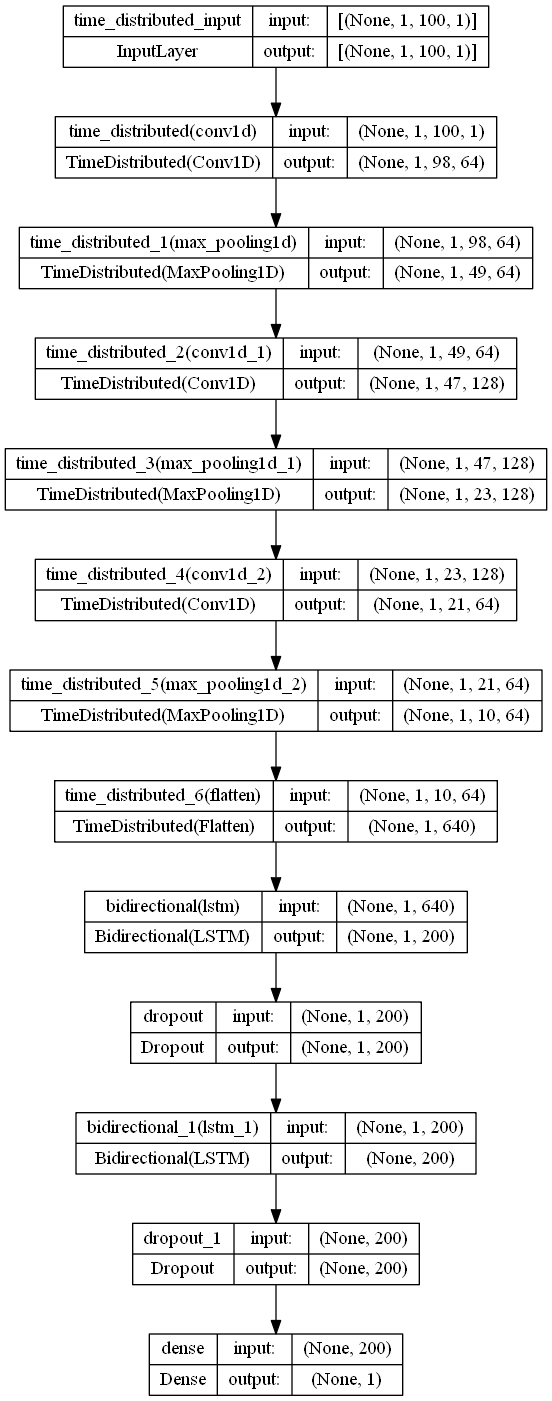

In [20]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [21]:
model.evaluate(test_X, test_Y)

28/28 [==============================] - 0s 6ms/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0427


[0.003127823118120432, 0.003127823118120432, 0.04265953227877617]

In [22]:
rmse =np.sqrt(np.mean((test_X-test_Y)**2))
rmse

0.2956090720906567

In [23]:
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

# predict probabilities for test set
yhat_probs = model.predict(test_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(test_Y.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(test_Y.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(test_Y.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

Variance: 0.944342
R2 Score: 0.944342
Max Error: 0.266743


28/28 [==============================] - 0s 6ms/step


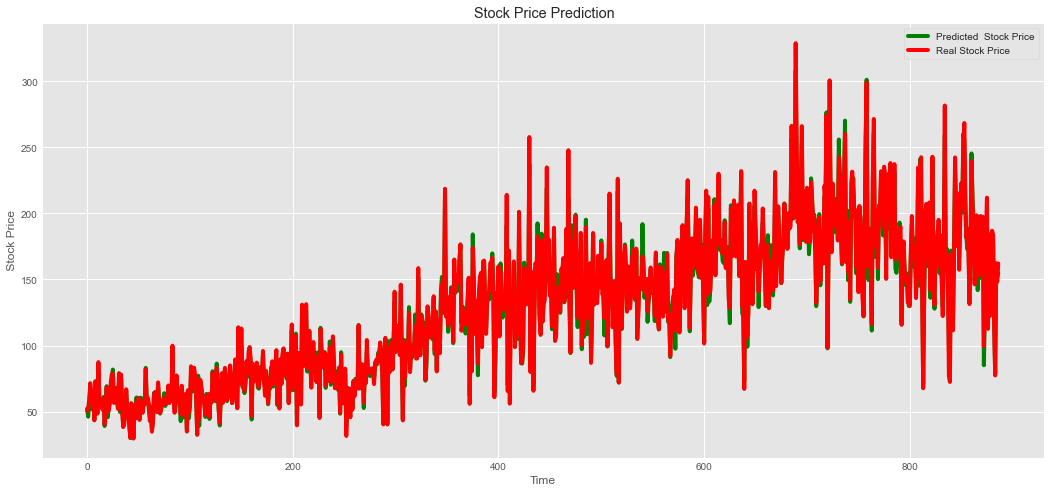

In [24]:
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp

plt.figure(figsize=(16,8))    
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()